### Notebook to visualize individual boxplot comparison of E3 mutated ligase versus their wild type counterparts

In [10]:
import pandas as pd
import numpy as np
import os
import re
import glob
import json
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection
from scipy import stats
import seaborn as sns

### Paths data

In [11]:
base="../../" 
# output drivers TCGA
path_drivers_tcga= os.path.join(base,"data","signals_E3_ligases_tcga.tsv")
# output
path_output_analysis= os.path.join(base,"data","output_e3_ligases_change_stability")
path_colors = os.path.join(base,"degrons",'positive_selection','analysis',"dict_colors.json")
# interacting pairs
output_pickle_annotated = os.path.join(base,'data', 'dict_annotated_pairs.json' )
output_pickle_all = os.path.join(base,'data', 'dict_all_pairs.json' )
# Plots 
path_output_plots = os.path.join(base,"plots","Figure6","individual_pairs")
# Data of RPPA
path_file_rppa =os.path.join(base,"data","rppa_matched_irls.tsv.gz")
samples_e3_mutated = os.path.join(base,"data","e3_mutated_grouped.csv")


### aux functions

In [12]:
def concat(grp):
    l = []
    for group_samples in grp:
        for sample in group_samples.split(","):
            l.append(sample)
    return ",".join(l)

### Read colors

In [13]:
dict_colors = json.load(open(path_colors,'r'))

### Read significant pairs

In [14]:
l = []
for filef in glob.glob(path_output_analysis+"/*_"+"tcga.tsv.gz"):
    df = pd.read_csv(filef,sep="\t")
    df = df[(df["Q_value"]<0.1)&(df["Type_Change"]=="increase")]
    l.append(df)
df_total = pd.concat(l)

### Read RPPA and samples mutated

In [15]:
df_diff_info = pd.read_csv(path_file_rppa,sep="\t",compression="gzip")
df_wt = df_diff_info[
            ((df_diff_info["Phenotype"] == "WT")) & (df_diff_info["CNA"] >= -1) & (df_diff_info["CNA"] <= 1) & (
                np.isfinite(df_diff_info["Stability_Change"]))]

df_samples_e3_mutated = pd.read_csv(samples_e3_mutated,sep="\t")

### Prepare the dataframe

In [16]:
protein_pairs = df_total[["Protein_Driver_Mutated","Protein","Cancer_Type","Hugo_Symbol"]].drop_duplicates()
protein_pairs

Protein_Driver_Mutated         Protein Cancer_Type Hugo_Symbol
8                    KEAP1            NRF2        LUAD      NFE2L2
8                    FBXW7        CYCLINE1        CESC       CCNE1
23                  MAP3K1  MAPK_pT202Y204        BRCA       MAPK3
1                      VHL       HIF1ALPHA        KIRC       HIF1A
34                   FBXW7            PTEN        UCEC        PTEN
55                  MYCBP2         TUBERIN        UCEC        TSC2
93                   UBE3A         TUBERIN        UCEC        TSC2
5                      APC             YAP    COADREAD        YAP1
16                   FBXW7        CYCLINE1    COADREAD       CCNE1
14                   FBXW7        CYCLINE1        HNSC       CCNE1
66                   FBXW7        CYCLINE1         PAN       CCNE1
68                   FBXW7            PTEN         PAN        PTEN
90                   KEAP1            NRF2         PAN      NFE2L2
183                  UBE3A         TUBERIN         PAN        TSC2

/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


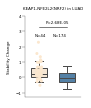

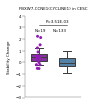

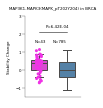

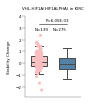

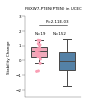

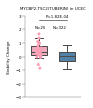

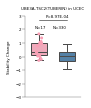

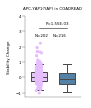

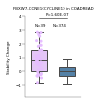

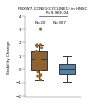

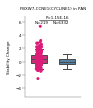

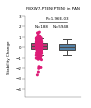

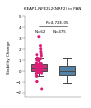

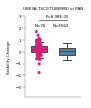

In [20]:
l = []
for e3,target,cancer,hugo in protein_pairs.values:
    
    if cancer != "PAN":
        # Select samples with mutations in the E3 ligase
        
        samples_e3=df_samples_e3_mutated[(df_samples_e3_mutated["Hugo_Symbol"]==e3)&(df_samples_e3_mutated["Cancer_Type"]==cancer)]["Matchable_Sample_ID"].values[0].split(",")
        # Get RPPA values of MT
        mutated_samples=df_wt[(df_wt["Protein"]==target)&(df_wt["Cancer_Type"]==cancer)&(df_wt["Matchable_Sample_ID"].isin(samples_e3))]
        # And WT
        wt_samples=df_wt[(df_wt["Protein"]==target)&(df_wt["Cancer_Type"]==cancer)&(~df_wt["Matchable_Sample_ID"].isin(samples_e3))]
    else:
        grouped_samples = df_samples_e3_mutated.groupby(["Hugo_Symbol"],as_index=False).agg({"COUNT_MUTS":np.nansum,"Matchable_Sample_ID":concat})
        # Select samples with mutations in the E3 ligase
        samples_e3=grouped_samples[(grouped_samples["Hugo_Symbol"]==e3)]["Matchable_Sample_ID"].values[0].split(",")
        # Get RPPA values of MT
        mutated_samples=df_wt[(df_wt["Protein"]==target)&(df_wt["Matchable_Sample_ID"].isin(samples_e3))]
        # And WT
        wt_samples=df_wt[(df_wt["Protein"]==target)&(~df_wt["Matchable_Sample_ID"].isin(samples_e3))]
 
    mt = mutated_samples["Stability_Change"].values
    wt = wt_samples["Stability_Change"].values
    pvalue = stats.mannwhitneyu(mt,wt,alternative="two-sided")
    mutated_samples["Type"] ="MT"
    wt_samples["Type"] = "WT"
    total = pd.concat([mutated_samples,wt_samples])
    fig,ax = plt.subplots(nrows=1,ncols=1)
    fig.set_size_inches(1, 1.5)
    pallete = {"MT":"#cc0000","WT":"#4682B4"}
    pallete["MT"] = dict_colors[cancer]
    s = ["MT","WT"]
    sns.boxplot(data=total,x="Type",y="Stability_Change",palette=pallete,whis=0.9,notch=False,fliersize=0,width=0.6,order=s,ax=ax,linewidth=1)
    sns.stripplot(data=total[total["Type"]=="MT"],x="Type",y="Stability_Change",size=3,palette=pallete,jitter=True,dodge=True,order=s)

    ax.set_xticklabels([],rotation=90,fontsize=6)
    ax.set_ylabel("Stability Change",fontsize=4)
    ax.set_xlabel("",fontsize=6)
    ax.set_title(e3+"-"+hugo+"("+target+")"+" in "+ cancer,fontsize=4)
    maxv = np.nanmax(mutated_samples["Stability_Change"].values)
    
    ax.axhline(y=maxv+1.0,xmin=0.25,xmax=0.75,color="black",lw=0.5)
    ax.text(y=maxv+1.2,x=0.25,s="P="+str("{0:.2E}".format(pvalue[1])),fontsize=4)
    ax.text(y=maxv+0.4,x=-0.15,s="N="+str(len(mt)),fontsize=4)
    ax.text(y=maxv+0.4,x=0.5,s="N="+str(len(wt)),fontsize=4)
    ax.set_ylim((ax.get_ylim()[0],int(maxv)+2))
    #ax.set_yticks(range(int(ax.get_ylim()[0])-1,int(maxv)+2,1))
    
    ax.tick_params(axis = 'y', labelsize =4  , pad=0.5 ,width=0.25)
    ax.tick_params(axis = 'x', labelsize =4  , pad=0.5 ,width=0.0)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(0.25)
    ax.spines['bottom'].set_linewidth(0.25)
    plt.savefig(path_output_plots+"/"+e3+"_"+target+"_"+cancer+'_TCGA.pdf', dpi=800,bbox_inches="tight")
    

    
